In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
if ".." not in sys.path:
    sys.path.append("..")

In [3]:
import os
import glob
import random
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from src.text_detection.net import *
from src.text_detection.loss import *
from src.text_detection.data import *
from src.text_detection.utils import *

# random.seed(42)

In [4]:
DATA_DIR_RAW = "../data/raw"
DATA_DIR_RAW_TRAIN = f"{DATA_DIR_RAW}/train"
DATA_DIR_RAW_TEST = f"{DATA_DIR_RAW}/test"
DATA_DIR_ANNOTATION_TRAIN = f"{DATA_DIR_RAW}/train"
DATA_DIR_ANNOTATION_TEST = f"{DATA_DIR_RAW}/test"

In [5]:
TRAIN_IMAGES = glob.glob(f"{DATA_DIR_RAW_TRAIN}/*.jpg")
TRAIN_OCR_ANNOTATIONS = [_ for _ in glob.glob(f"{DATA_DIR_ANNOTATION_TRAIN}/*.json") if "_ocr" in _]
TEST_IMAGES = glob.glob(f"{DATA_DIR_RAW_TEST}/*.jpg")
TEST_OCR_ANNOTATIONS = [_ for _ in glob.glob(f"{DATA_DIR_ANNOTATION_TEST}/*.json") if "_ocr" in _]

print(f"There are altogether {len(TRAIN_IMAGES)} images in the train directory.")
print(f"Corresponding to these, there are {len(TRAIN_OCR_ANNOTATIONS)} annotations in the train directory.")
print(f"There are altogether {len(TEST_IMAGES)} images in the test directory.")
print(f"Corresponding to these, there are {len(TEST_OCR_ANNOTATIONS)} annotations in the test directory.")

There are altogether 626 images in the train directory.
Corresponding to these, there are 626 annotations in the train directory.
There are altogether 361 images in the test directory.
Corresponding to these, there are 361 annotations in the test directory.


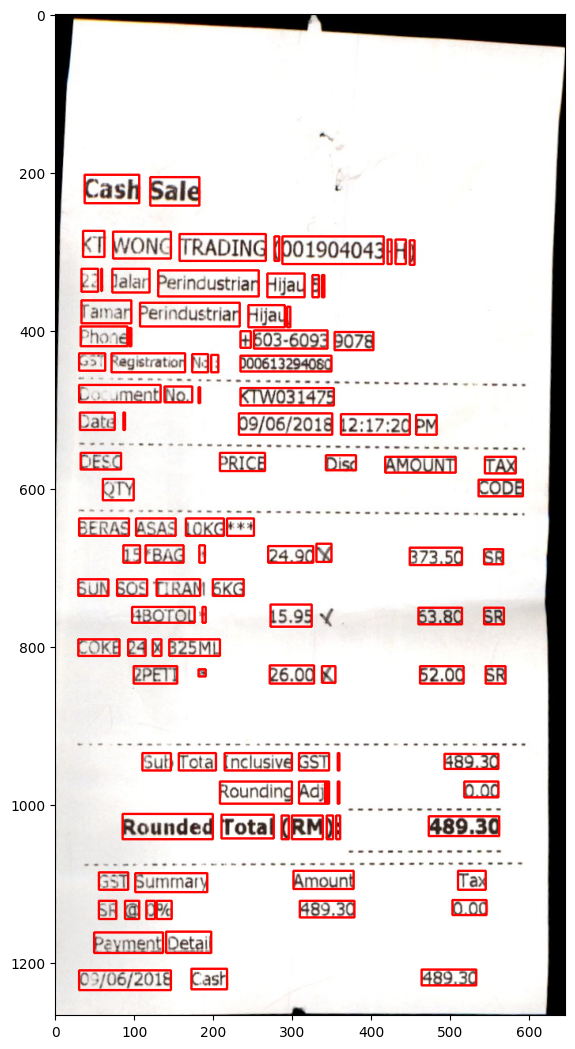

In [ ]:
img = random.choice(TRAIN_IMAGES)
visualize_image(img, get_annotated_file(img))

In [7]:
x, y = generate_region_affinity_heatmap(image_path=img)
image = normalize_image(np.asarray(Image.open(img)))

Image and region map


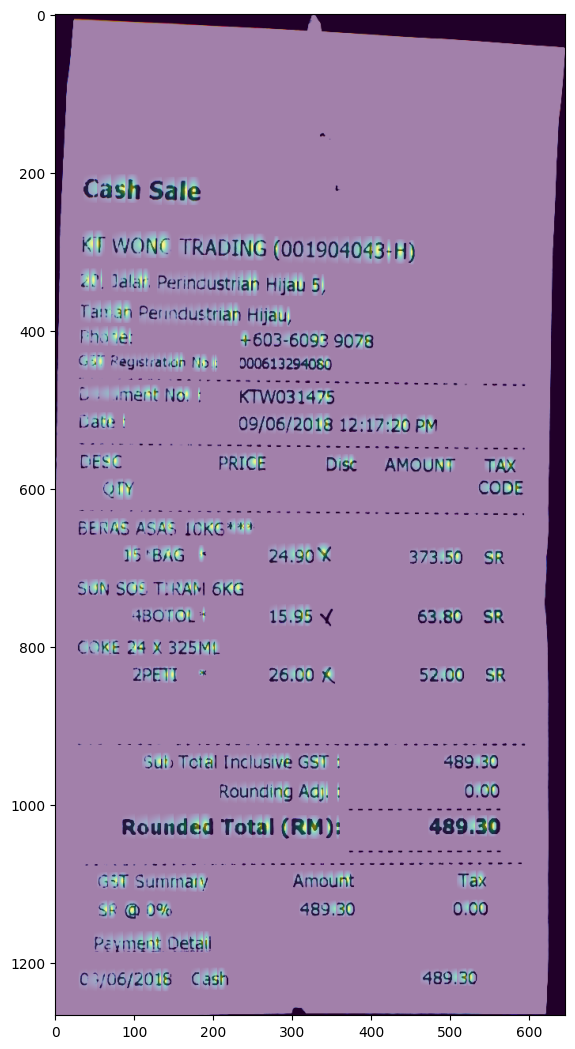

In [8]:
print("Image and region map")
visualize_ndarray_image(images=[image, x], opacity=[1, 0.5])

Image and affinity map


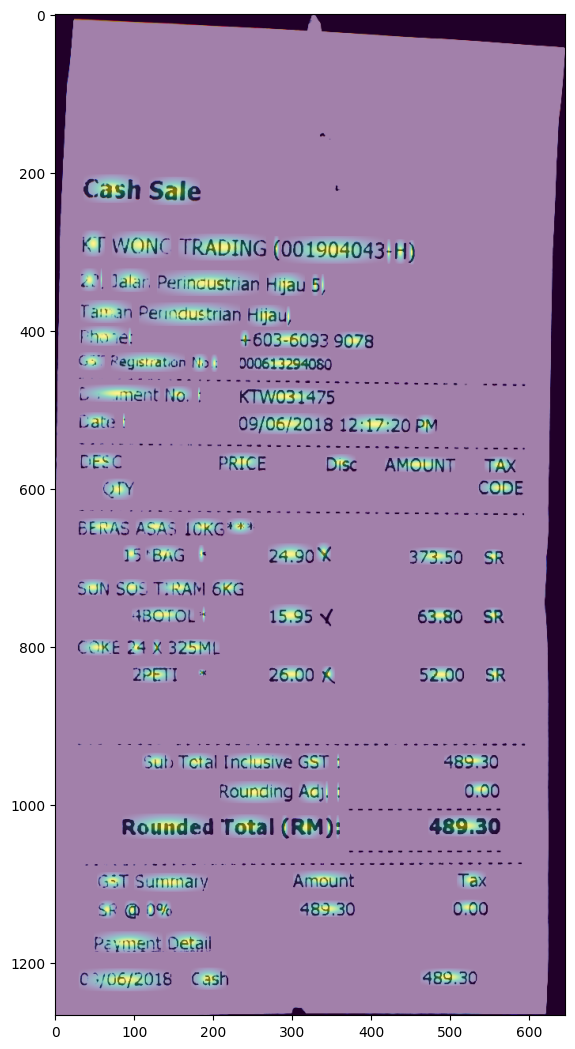

In [9]:
print("Image and affinity map")
visualize_ndarray_image(images=[image, y], opacity=[1, 0.5])

In [10]:
train_df = get_df(DATA_DIR_RAW_TRAIN)
test_df = get_df(DATA_DIR_RAW_TEST)

In [11]:
train_df.head()

,image,annotations
0,../data/raw/train/X51005442376.jpg,../data/raw/train/X51005442376_ocr.json
1,../data/raw/train/X51009453804.jpg,../data/raw/train/X51009453804_ocr.json
2,../data/raw/train/X51006401723.jpg,../data/raw/train/X51006401723_ocr.json
3,../data/raw/train/X51006913023.jpg,../data/raw/train/X51006913023_ocr.json
4,../data/raw/train/X51007846451.jpg,../data/raw/train/X51007846451_ocr.json


In [12]:
train_df, val_df = split_data(df=train_df, split_ratio=[0.8])
print(f"Length of train_df = {len(train_df)}")
print(f"Length of val_df = {len(val_df)}")
print(f"Length of test_df = {len(test_df)}")

Length of train_df = 500
Length of val_df = 126
Length of test_df = 361


In [13]:
# Get data loaders and visualize its output
data_generator = OCRData(train_data=train_df, val_data=val_df, test_data=test_df, train_batch_size=8, val_batch_size=8, test_batch_size=8)

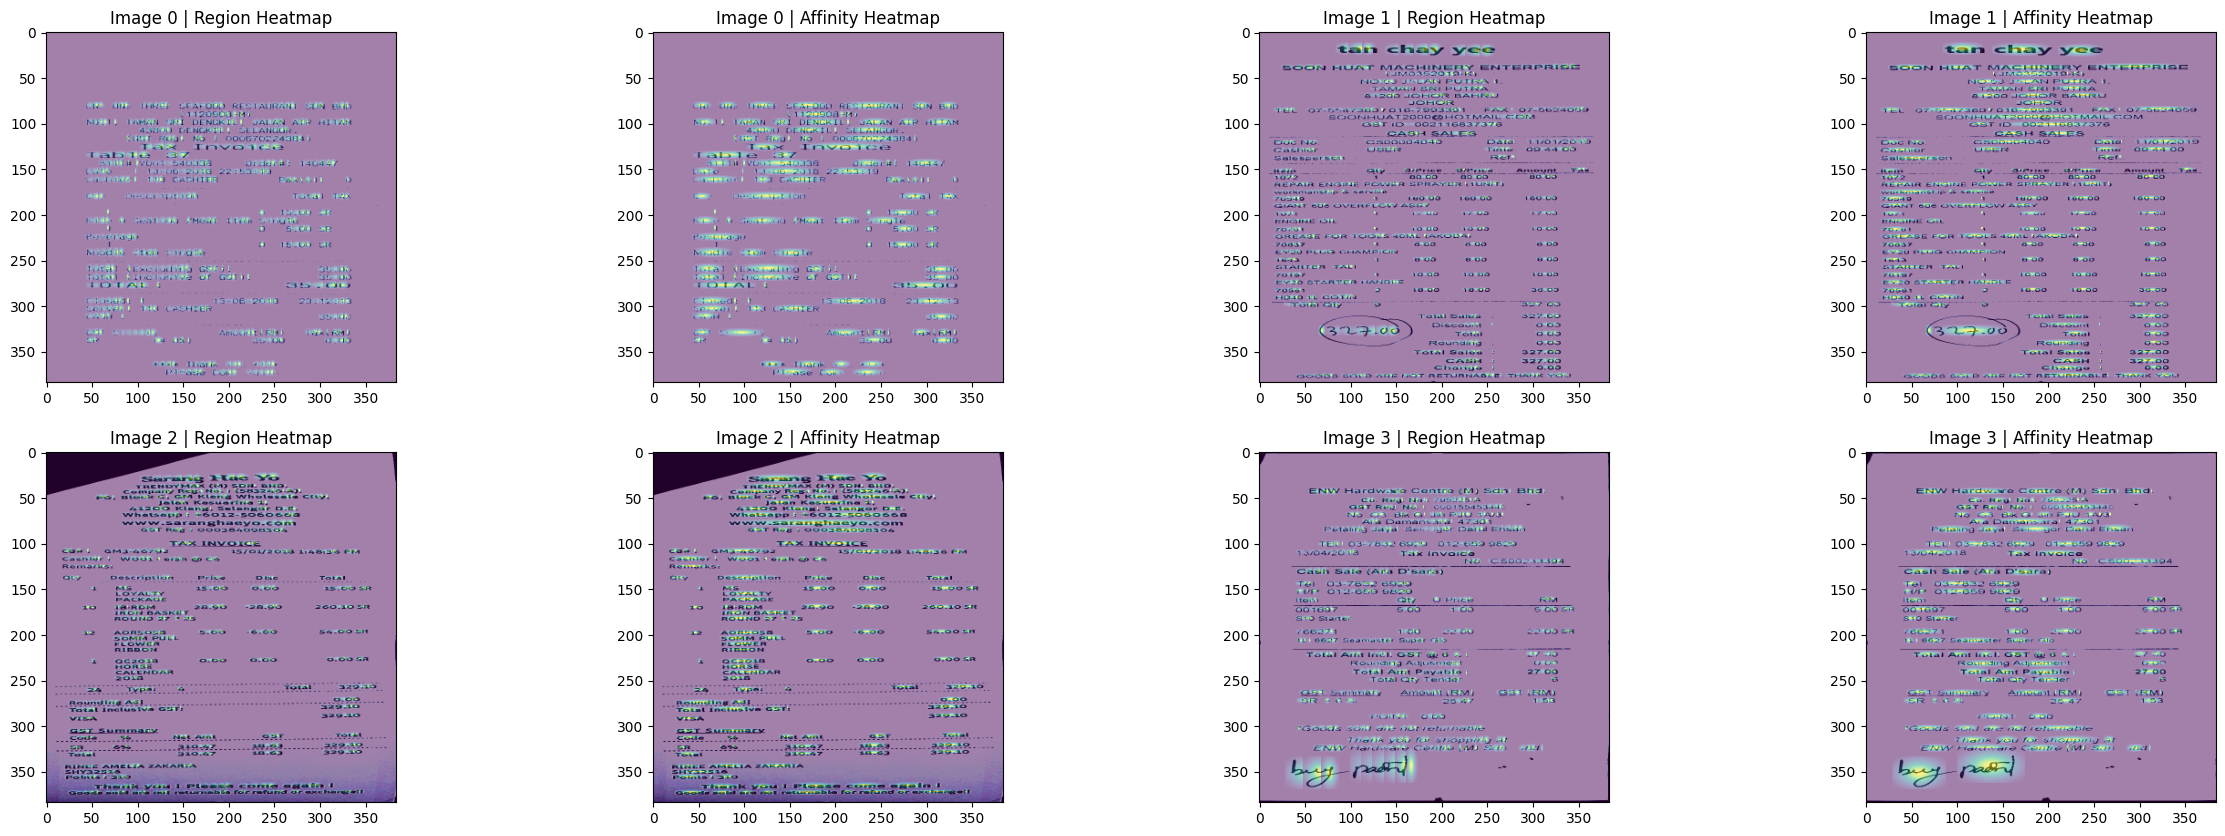

In [14]:
data_generator.visualize()

In [15]:
train_loader, val_loader, test_loader = data_generator.get_data_loaders()

In [16]:
model = LitOCRModel(
    criteria=JointMSELoss(),
    loaders={
        "train": train_loader,
        "validation": val_loader,
        "test": test_loader
    },
    saved_model="../src/text_detection/models/downloaded_model/craft/craft_mlt_25k.pth"
)

RuntimeError: Error(s) in loading state_dict for CRAFT:
	Missing key(s) in state_dict: "basenet.slice_1.0.weight", "basenet.slice_1.0.bias", "basenet.slice_1.1.weight", "basenet.slice_1.1.bias", "basenet.slice_1.1.running_mean", "basenet.slice_1.1.running_var", "basenet.slice_1.3.weight", "basenet.slice_1.3.bias", "basenet.slice_1.4.weight", "basenet.slice_1.4.bias", "basenet.slice_1.4.running_mean", "basenet.slice_1.4.running_var", "basenet.slice_1.7.weight", "basenet.slice_1.7.bias", "basenet.slice_1.8.weight", "basenet.slice_1.8.bias", "basenet.slice_1.8.running_mean", "basenet.slice_1.8.running_var", "basenet.slice_1.10.weight", "basenet.slice_1.10.bias", "basenet.slice_1.11.weight", "basenet.slice_1.11.bias", "basenet.slice_1.11.running_mean", "basenet.slice_1.11.running_var", "basenet.slice_2.14.weight", "basenet.slice_2.14.bias", "basenet.slice_2.15.weight", "basenet.slice_2.15.bias", "basenet.slice_2.15.running_mean", "basenet.slice_2.15.running_var", "basenet.slice_2.17.weight", "basenet.slice_2.17.bias", "basenet.slice_2.18.weight", "basenet.slice_2.18.bias", "basenet.slice_2.18.running_mean", "basenet.slice_2.18.running_var", "basenet.slice_3.20.weight", "basenet.slice_3.20.bias", "basenet.slice_3.21.weight", "basenet.slice_3.21.bias", "basenet.slice_3.21.running_mean", "basenet.slice_3.21.running_var", "basenet.slice_3.24.weight", "basenet.slice_3.24.bias", "basenet.slice_3.25.weight", "basenet.slice_3.25.bias", "basenet.slice_3.25.running_mean", "basenet.slice_3.25.running_var", "basenet.slice_3.27.weight", "basenet.slice_3.27.bias", "basenet.slice_3.28.weight", "basenet.slice_3.28.bias", "basenet.slice_3.28.running_mean", "basenet.slice_3.28.running_var", "basenet.slice_4.30.weight", "basenet.slice_4.30.bias", "basenet.slice_4.31.weight", "basenet.slice_4.31.bias", "basenet.slice_4.31.running_mean", "basenet.slice_4.31.running_var", "basenet.slice_4.34.weight", "basenet.slice_4.34.bias", "basenet.slice_4.35.weight", "basenet.slice_4.35.bias", "basenet.slice_4.35.running_mean", "basenet.slice_4.35.running_var", "basenet.slice_4.37.weight", "basenet.slice_4.37.bias", "basenet.slice_4.38.weight", "basenet.slice_4.38.bias", "basenet.slice_4.38.running_mean", "basenet.slice_4.38.running_var", "basenet.slice_5.1.weight", "basenet.slice_5.1.bias", "basenet.slice_5.2.weight", "basenet.slice_5.2.bias", "upconv1.conv2d.0.weight", "upconv1.conv2d.0.bias", "upconv1.conv2d.1.weight", "upconv1.conv2d.1.bias", "upconv1.conv2d.1.running_mean", "upconv1.conv2d.1.running_var", "upconv1.conv2d.3.weight", "upconv1.conv2d.3.bias", "upconv1.conv2d.4.weight", "upconv1.conv2d.4.bias", "upconv1.conv2d.4.running_mean", "upconv1.conv2d.4.running_var", "upconv2.conv2d.0.weight", "upconv2.conv2d.0.bias", "upconv2.conv2d.1.weight", "upconv2.conv2d.1.bias", "upconv2.conv2d.1.running_mean", "upconv2.conv2d.1.running_var", "upconv2.conv2d.3.weight", "upconv2.conv2d.3.bias", "upconv2.conv2d.4.weight", "upconv2.conv2d.4.bias", "upconv2.conv2d.4.running_mean", "upconv2.conv2d.4.running_var", "upconv3.conv2d.0.weight", "upconv3.conv2d.0.bias", "upconv3.conv2d.1.weight", "upconv3.conv2d.1.bias", "upconv3.conv2d.1.running_mean", "upconv3.conv2d.1.running_var", "upconv3.conv2d.3.weight", "upconv3.conv2d.3.bias", "upconv3.conv2d.4.weight", "upconv3.conv2d.4.bias", "upconv3.conv2d.4.running_mean", "upconv3.conv2d.4.running_var", "upconv4.conv2d.0.weight", "upconv4.conv2d.0.bias", "upconv4.conv2d.1.weight", "upconv4.conv2d.1.bias", "upconv4.conv2d.1.running_mean", "upconv4.conv2d.1.running_var", "upconv4.conv2d.3.weight", "upconv4.conv2d.3.bias", "upconv4.conv2d.4.weight", "upconv4.conv2d.4.bias", "upconv4.conv2d.4.running_mean", "upconv4.conv2d.4.running_var", "conv_cls.0.weight", "conv_cls.0.bias", "conv_cls.2.weight", "conv_cls.2.bias", "conv_cls.4.weight", "conv_cls.4.bias", "conv_cls.6.weight", "conv_cls.6.bias", "conv_cls.8.weight", "conv_cls.8.bias". 
	Unexpected key(s) in state_dict: "module.basenet.slice1.0.weight", "module.basenet.slice1.0.bias", "module.basenet.slice1.1.weight", "module.basenet.slice1.1.bias", "module.basenet.slice1.1.running_mean", "module.basenet.slice1.1.running_var", "module.basenet.slice1.1.num_batches_tracked", "module.basenet.slice1.3.weight", "module.basenet.slice1.3.bias", "module.basenet.slice1.4.weight", "module.basenet.slice1.4.bias", "module.basenet.slice1.4.running_mean", "module.basenet.slice1.4.running_var", "module.basenet.slice1.4.num_batches_tracked", "module.basenet.slice1.7.weight", "module.basenet.slice1.7.bias", "module.basenet.slice1.8.weight", "module.basenet.slice1.8.bias", "module.basenet.slice1.8.running_mean", "module.basenet.slice1.8.running_var", "module.basenet.slice1.8.num_batches_tracked", "module.basenet.slice1.10.weight", "module.basenet.slice1.10.bias", "module.basenet.slice1.11.weight", "module.basenet.slice1.11.bias", "module.basenet.slice1.11.running_mean", "module.basenet.slice1.11.running_var", "module.basenet.slice1.11.num_batches_tracked", "module.basenet.slice2.14.weight", "module.basenet.slice2.14.bias", "module.basenet.slice2.15.weight", "module.basenet.slice2.15.bias", "module.basenet.slice2.15.running_mean", "module.basenet.slice2.15.running_var", "module.basenet.slice2.15.num_batches_tracked", "module.basenet.slice2.17.weight", "module.basenet.slice2.17.bias", "module.basenet.slice2.18.weight", "module.basenet.slice2.18.bias", "module.basenet.slice2.18.running_mean", "module.basenet.slice2.18.running_var", "module.basenet.slice2.18.num_batches_tracked", "module.basenet.slice3.20.weight", "module.basenet.slice3.20.bias", "module.basenet.slice3.21.weight", "module.basenet.slice3.21.bias", "module.basenet.slice3.21.running_mean", "module.basenet.slice3.21.running_var", "module.basenet.slice3.21.num_batches_tracked", "module.basenet.slice3.24.weight", "module.basenet.slice3.24.bias", "module.basenet.slice3.25.weight", "module.basenet.slice3.25.bias", "module.basenet.slice3.25.running_mean", "module.basenet.slice3.25.running_var", "module.basenet.slice3.25.num_batches_tracked", "module.basenet.slice3.27.weight", "module.basenet.slice3.27.bias", "module.basenet.slice3.28.weight", "module.basenet.slice3.28.bias", "module.basenet.slice3.28.running_mean", "module.basenet.slice3.28.running_var", "module.basenet.slice3.28.num_batches_tracked", "module.basenet.slice4.30.weight", "module.basenet.slice4.30.bias", "module.basenet.slice4.31.weight", "module.basenet.slice4.31.bias", "module.basenet.slice4.31.running_mean", "module.basenet.slice4.31.running_var", "module.basenet.slice4.31.num_batches_tracked", "module.basenet.slice4.34.weight", "module.basenet.slice4.34.bias", "module.basenet.slice4.35.weight", "module.basenet.slice4.35.bias", "module.basenet.slice4.35.running_mean", "module.basenet.slice4.35.running_var", "module.basenet.slice4.35.num_batches_tracked", "module.basenet.slice4.37.weight", "module.basenet.slice4.37.bias", "module.basenet.slice4.38.weight", "module.basenet.slice4.38.bias", "module.basenet.slice4.38.running_mean", "module.basenet.slice4.38.running_var", "module.basenet.slice4.38.num_batches_tracked", "module.basenet.slice5.1.weight", "module.basenet.slice5.1.bias", "module.basenet.slice5.2.weight", "module.basenet.slice5.2.bias", "module.upconv1.conv.0.weight", "module.upconv1.conv.0.bias", "module.upconv1.conv.1.weight", "module.upconv1.conv.1.bias", "module.upconv1.conv.1.running_mean", "module.upconv1.conv.1.running_var", "module.upconv1.conv.1.num_batches_tracked", "module.upconv1.conv.3.weight", "module.upconv1.conv.3.bias", "module.upconv1.conv.4.weight", "module.upconv1.conv.4.bias", "module.upconv1.conv.4.running_mean", "module.upconv1.conv.4.running_var", "module.upconv1.conv.4.num_batches_tracked", "module.upconv2.conv.0.weight", "module.upconv2.conv.0.bias", "module.upconv2.conv.1.weight", "module.upconv2.conv.1.bias", "module.upconv2.conv.1.running_mean", "module.upconv2.conv.1.running_var", "module.upconv2.conv.1.num_batches_tracked", "module.upconv2.conv.3.weight", "module.upconv2.conv.3.bias", "module.upconv2.conv.4.weight", "module.upconv2.conv.4.bias", "module.upconv2.conv.4.running_mean", "module.upconv2.conv.4.running_var", "module.upconv2.conv.4.num_batches_tracked", "module.upconv3.conv.0.weight", "module.upconv3.conv.0.bias", "module.upconv3.conv.1.weight", "module.upconv3.conv.1.bias", "module.upconv3.conv.1.running_mean", "module.upconv3.conv.1.running_var", "module.upconv3.conv.1.num_batches_tracked", "module.upconv3.conv.3.weight", "module.upconv3.conv.3.bias", "module.upconv3.conv.4.weight", "module.upconv3.conv.4.bias", "module.upconv3.conv.4.running_mean", "module.upconv3.conv.4.running_var", "module.upconv3.conv.4.num_batches_tracked", "module.upconv4.conv.0.weight", "module.upconv4.conv.0.bias", "module.upconv4.conv.1.weight", "module.upconv4.conv.1.bias", "module.upconv4.conv.1.running_mean", "module.upconv4.conv.1.running_var", "module.upconv4.conv.1.num_batches_tracked", "module.upconv4.conv.3.weight", "module.upconv4.conv.3.bias", "module.upconv4.conv.4.weight", "module.upconv4.conv.4.bias", "module.upconv4.conv.4.running_mean", "module.upconv4.conv.4.running_var", "module.upconv4.conv.4.num_batches_tracked", "module.conv_cls.0.weight", "module.conv_cls.0.bias", "module.conv_cls.2.weight", "module.conv_cls.2.bias", "module.conv_cls.4.weight", "module.conv_cls.4.bias", "module.conv_cls.6.weight", "module.conv_cls.6.bias", "module.conv_cls.8.weight", "module.conv_cls.8.bias". 

In [ ]:
# LR Finder
# trainer = pl.Trainer(auto_lr_find=True, gpus=1 if torch.cuda.is_available() else None
trainer = pl.Trainer(auto_lr_find=True, accelerator="mps", default_root_dir="../logs/lr_finder/text_detection")
# Version issue: `tuner` disintegrated from `pl.Trainer`. Alertnative: use `pl.tuner.Tuner(trainer)` followed by
# `tuner.lr_find(model)`
lr_finder = trainer.tuner.lr_find(model)
fig = lr_finder.plot(suggest=True)
fig.show()

In [ ]:
# Path to pre-trained model
resume_from_checkpoint = None
# Path for logging
trainer = pl.Trainer(
    precision=32,
    limit_train_batches=0.5,
    accelerator="mps",
    max_epochs=1,
    logger=TensorBoardLogger("../logs/text_detection_logs"),
    callbacks=[
        LearningRateMonitor(logging_interval="step"),
        ModelCheckpoint(monitor="val_loss")
    ],
    resume_from_checkpoint=resume_from_checkpoint
)
trainer.fit(model)

In [ ]:
trainer.test(ckpt_path="best")

In [ ]:
model